# 02 - Analysis: Train District Classifier

Train a classifier to predict Kerala districts from VAE embeddings.

**Goal:** Train and evaluate a Random Forest classifier on the embeddings.

**Steps:**
1. Load processed embeddings with district labels
2. Split into train/test sets
3. Train Random Forest classifier
4. Evaluate performance
5. Save trained model

## Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Add backbone to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current project: {Path.cwd().parent.name}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
Current project: district_prediction


## 1. Load Processed Data

In [2]:
# Load embeddings with district labels from 01_exploration.ipynb
data_path = Path('../data/processed/embeddings_with_districts.npz')

print(f'Loading data from: {data_path}')
data = np.load(data_path, allow_pickle=True)

X = data['embeddings']
y = data['districts']

print(f'\n✓ Loaded dataset')
print(f'  Samples: {len(X):,}')
print(f'  Features (embedding dim): {X.shape[1]}')
print(f'  Districts: {len(np.unique(y))}')
print(f'\nDistrict distribution:')
for district, count in pd.Series(y).value_counts().items():
    print(f'  {district:20s}: {count:5,} ({count/len(y)*100:5.2f}%)')

Loading data from: ..\data\processed\embeddings_with_districts.npz

✓ Loaded dataset
  Samples: 64,884
  Features (embedding dim): 16
  Districts: 14

District distribution:
  Thrissur            : 14,850 (22.89%)
  Alappuzha           : 11,721 (18.06%)
  Ernakulam           : 11,458 (17.66%)
  Palakkad            : 6,968 (10.74%)
  Kannur              : 4,866 ( 7.50%)
  Idukki              : 2,720 ( 4.19%)
  Pathanamthitta      : 2,225 ( 3.43%)
  Thiruvananthapuram  : 2,043 ( 3.15%)
  Kottayam            : 1,995 ( 3.07%)
  Kozhikode           : 1,643 ( 2.53%)
  Malappuram          : 1,623 ( 2.50%)
  Wayanad             : 1,093 ( 1.68%)
  Kollam              : 1,023 ( 1.58%)
  Kasaragod           :   656 ( 1.01%)


## 2. Train/Test Split

In [3]:
# Stratified split to maintain district distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'Dataset split:')
print(f'  Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)')
print(f'  Test:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)')
print(f'\nTrain distribution:')
for district, count in pd.Series(y_train).value_counts().items():
    print(f'  {district:20s}: {count:5,}')
print(f'\nTest distribution:')
for district, count in pd.Series(y_test).value_counts().items():
    print(f'  {district:20s}: {count:5,}')

Dataset split:
  Train: 51,907 samples (80.0%)
  Test:  12,977 samples (20.0%)

Train distribution:
  Thrissur            : 11,880
  Alappuzha           : 9,377
  Ernakulam           : 9,166
  Palakkad            : 5,574
  Kannur              : 3,893
  Idukki              : 2,176
  Pathanamthitta      : 1,780
  Thiruvananthapuram  : 1,634
  Kottayam            : 1,596
  Kozhikode           : 1,314
  Malappuram          : 1,298
  Wayanad             :   875
  Kollam              :   819
  Kasaragod           :   525

Test distribution:
  Thrissur            : 2,970
  Alappuzha           : 2,344
  Ernakulam           : 2,292
  Palakkad            : 1,394
  Kannur              :   973
  Idukki              :   544
  Pathanamthitta      :   445
  Thiruvananthapuram  :   409
  Kottayam            :   399
  Kozhikode           :   329
  Malappuram          :   325
  Wayanad             :   218
  Kollam              :   204
  Kasaragod           :   131


## 3. Train Random Forest Classifier

In [4]:
# Create classifier
clf = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=20,            # Maximum tree depth
    min_samples_split=5,     # Minimum samples to split a node
    min_samples_leaf=2,      # Minimum samples at leaf
    random_state=42,
    n_jobs=-1,               # Use all CPU cores
    verbose=1                # Show progress
)

print('Training Random Forest Classifier...')
print(f'  n_estimators: {clf.n_estimators}')
print(f'  max_depth: {clf.max_depth}')
print(f'  Using all CPU cores\n')

clf.fit(X_train, y_train)

print('\n✓ Training complete!')

Training Random Forest Classifier...
  n_estimators: 200
  max_depth: 20
  Using all CPU cores



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.6s



✓ Training complete!


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.2s finished


## 4. Evaluate Performance

In [5]:
# Predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('='*60)
print('PERFORMANCE SUMMARY')
print('='*60)
print(f'\nTrain Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)')
print(f'Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'\nOverfitting check: {(train_acc - test_acc)*100:.2f}% gap')
print('='*60)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


PERFORMANCE SUMMARY

Train Accuracy: 0.9242 (92.42%)
Test Accuracy:  0.6745 (67.45%)

Overfitting check: 24.97% gap


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


In [6]:
# Detailed classification report
print('\nClassification Report (Test Set):')
print('='*60)
print(classification_report(y_test, y_test_pred, digits=3))


Classification Report (Test Set):
                    precision    recall  f1-score   support

         Alappuzha      0.665     0.814     0.732      2344
         Ernakulam      0.628     0.704     0.664      2292
            Idukki      0.773     0.746     0.760       544
            Kannur      0.703     0.609     0.653       973
         Kasaragod      0.900     0.137     0.238       131
            Kollam      0.860     0.240     0.375       204
          Kottayam      0.790     0.368     0.503       399
         Kozhikode      0.707     0.176     0.282       329
        Malappuram      0.818     0.372     0.512       325
          Palakkad      0.785     0.661     0.718      1394
    Pathanamthitta      0.667     0.216     0.326       445
Thiruvananthapuram      0.770     0.443     0.562       409
          Thrissur      0.637     0.865     0.734      2970
           Wayanad      0.766     0.330     0.462       218

          accuracy                          0.675     12977
   

In [7]:
# Get per-class metrics
report_dict = classification_report(y_test, y_test_pred, output_dict=True)

# Create summary dataframe
districts = sorted(np.unique(y))
summary_df = pd.DataFrame({
    'District': districts,
    'Precision': [report_dict[d]['precision'] for d in districts],
    'Recall': [report_dict[d]['recall'] for d in districts],
    'F1-Score': [report_dict[d]['f1-score'] for d in districts],
    'Support': [report_dict[d]['support'] for d in districts]
})

print('\nPer-District Metrics:')
print(summary_df.to_string(index=False))


Per-District Metrics:
          District  Precision   Recall  F1-Score  Support
         Alappuzha   0.665387 0.813567  0.732054   2344.0
         Ernakulam   0.628360 0.703752  0.663923   2292.0
            Idukki   0.773333 0.746324  0.759588    544.0
            Kannur   0.703440 0.609455  0.653084    973.0
         Kasaragod   0.900000 0.137405  0.238411    131.0
            Kollam   0.859649 0.240196  0.375479    204.0
          Kottayam   0.790323 0.368421  0.502564    399.0
         Kozhikode   0.707317 0.176292  0.282238    329.0
        Malappuram   0.817568 0.372308  0.511628    325.0
          Palakkad   0.784681 0.661406  0.717789   1394.0
    Pathanamthitta   0.666667 0.215730  0.325976    445.0
Thiruvananthapuram   0.770213 0.442543  0.562112    409.0
          Thrissur   0.636927 0.865320  0.733762   2970.0
           Wayanad   0.765957 0.330275  0.461538    218.0


## 5. Feature Importance

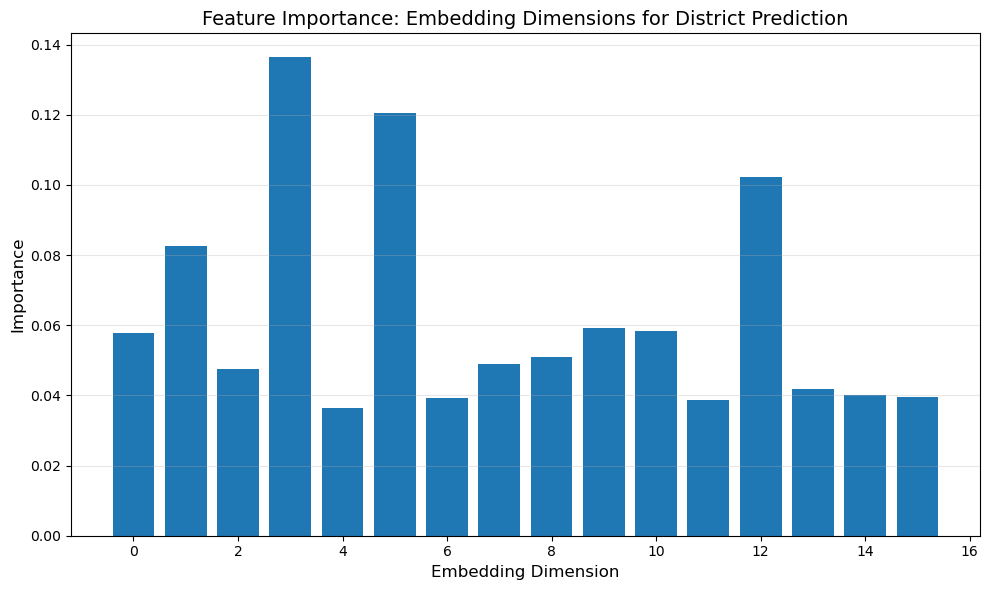


Most important dimensions:
  1. Dimension 3: 0.1364
  2. Dimension 5: 0.1204
  3. Dimension 12: 0.1022
  4. Dimension 1: 0.0827
  5. Dimension 9: 0.0591


In [8]:
# Get feature importances (which embedding dimensions matter most)
importances = clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Embedding Dimension', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importance: Embedding Dimensions for District Prediction', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nMost important dimensions:')
top_dims = np.argsort(importances)[::-1][:5]
for i, dim in enumerate(top_dims, 1):
    print(f'  {i}. Dimension {dim}: {importances[dim]:.4f}')

## 6. Sample Predictions

In [9]:
# Show some example predictions
n_samples = 20
sample_df = pd.DataFrame({
    'True District': y_test[:n_samples],
    'Predicted District': y_test_pred[:n_samples],
    'Correct': y_test[:n_samples] == y_test_pred[:n_samples]
})

print(f'\nSample Predictions (first {n_samples}):')
print(sample_df.to_string(index=False))
print(f'\nCorrect: {sample_df["Correct"].sum()}/{n_samples} ({sample_df["Correct"].sum()/n_samples*100:.1f}%)')


Sample Predictions (first 20):
     True District Predicted District  Correct
         Ernakulam          Ernakulam     True
          Thrissur           Thrissur     True
          Palakkad           Thrissur    False
          Thrissur           Thrissur     True
    Pathanamthitta          Ernakulam    False
         Alappuzha          Alappuzha     True
         Ernakulam           Thrissur    False
         Ernakulam          Ernakulam     True
         Ernakulam          Ernakulam     True
         Alappuzha          Alappuzha     True
          Thrissur           Thrissur     True
Thiruvananthapuram          Alappuzha    False
          Palakkad           Palakkad     True
         Alappuzha          Alappuzha     True
            Kannur             Kannur     True
         Ernakulam          Ernakulam     True
          Thrissur           Thrissur     True
          Thrissur           Thrissur     True
          Thrissur           Thrissur     True
Thiruvananthapuram Thiruvana

## 7. Save Model and Results

In [10]:
# Save trained model
model_path = Path('../models/district_classifier.pkl')
model_path.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(clf, model_path)
print(f'✓ Saved model to: {model_path}')
print(f'  File size: {model_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved model to: ..\models\district_classifier.pkl
  File size: 441.06 MB


In [11]:
# Save metrics as JSON
metrics = {
    'train_accuracy': float(train_acc),
    'test_accuracy': float(test_acc),
    'n_train': int(len(X_train)),
    'n_test': int(len(X_test)),
    'n_districts': int(len(np.unique(y))),
    'districts': list(np.unique(y)),
    'model_params': {
        'n_estimators': clf.n_estimators,
        'max_depth': clf.max_depth,
        'min_samples_split': clf.min_samples_split
    }
}

metrics_path = Path('../results/tables/metrics.json')
metrics_path.parent.mkdir(parents=True, exist_ok=True)

with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f'✓ Saved metrics to: {metrics_path}')

✓ Saved metrics to: ..\results\tables\metrics.json


In [12]:
# Save per-district metrics
summary_path = Path('../results/tables/district_metrics.csv')
summary_df.to_csv(summary_path, index=False)

print(f'✓ Saved district metrics to: {summary_path}')

✓ Saved district metrics to: ..\results\tables\district_metrics.csv


In [13]:
# Save sample predictions
predictions_path = Path('../results/tables/sample_predictions.csv')
sample_df.to_csv(predictions_path, index=False)

print(f'✓ Saved sample predictions to: {predictions_path}')

✓ Saved sample predictions to: ..\results\tables\sample_predictions.csv


## Summary

In [14]:
print('='*60)
print('ANALYSIS COMPLETE')
print('='*60)
print(f'\n📊 Model Performance:')
print(f'   Train Accuracy: {train_acc*100:.2f}%')
print(f'   Test Accuracy:  {test_acc*100:.2f}%')
print(f'\n🎯 Classification:')
print(f'   Districts: {len(np.unique(y))}')
print(f'   Training samples: {len(X_train):,}')
print(f'   Test samples: {len(X_test):,}')
print(f'\n💾 Outputs:')
print(f'   Model: models/district_classifier.pkl')
print(f'   Metrics: results/tables/metrics.json')
print(f'   District metrics: results/tables/district_metrics.csv')
print(f'   Sample predictions: results/tables/sample_predictions.csv')
print(f'\n✨ Ready for visualization!')
print('   Next: Run 03_results.ipynb')
print('='*60)

ANALYSIS COMPLETE

📊 Model Performance:
   Train Accuracy: 92.42%
   Test Accuracy:  67.45%

🎯 Classification:
   Districts: 14
   Training samples: 51,907
   Test samples: 12,977

💾 Outputs:
   Model: models/district_classifier.pkl
   Metrics: results/tables/metrics.json
   District metrics: results/tables/district_metrics.csv
   Sample predictions: results/tables/sample_predictions.csv

✨ Ready for visualization!
   Next: Run 03_results.ipynb
